## Monte Carlo simulation for NVT Ensemble

Reference: Computer Simulation of Liquid, 2017

Import packages

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from itertools import product

import sys
import time

from MonteCarlo import MonteCarlo
from PotentialType import PotentialType

In [2]:
import build.MonteCarlo as MC

In [3]:
box = np.array( [10, 10, 10] )
vol = np.prod( box )
num = 200
rho = float(num) / vol

rCut  = 2.5
drMax = 0.25
cells = np.ceil( float( num  / np.prod( box ) )**(1./3.) * box )
cells = cells.astype(np.int64)

temperature = 2.

r = np.zeros([num, 3])
r = MonteCarlo.initCoords(r, cells)

# Initial energy and check the particle position
total = MonteCarlo.potential ( box, rCut, r )
assert not total.ovr, "Overlap in the initial configuration"

mc = MC.MonteCarlo(num, 3, temperature, rCut, True)
mc.SetBox( box )

# Initial energy and check the particle position, CPP veraion
mc.SetPosition( r )
total1 = mc.GetPotential()

print( "CPP total potential: " + str(total1["pot"]))
print( "Py  total potential: " + str(total.pot))
print( "CPP total Virial: " + str(total1["vir"]))
print( "Py  total Virial: " + str(total.vir))

results = mc.MoveParticles( drMax )
total2  = PotentialType ( pot=results["pot"], vir=results["vir"], ovr= False ) + total

total1 = mc.GetPotential()

r1    = mc.GetPosition()
total = MonteCarlo.potential ( box, rCut, r1 )

print("********* after displacement particle *********")
print( "CPP total potential: " + str(total1["pot"]))
print( "CPP total potential 2: " + str(total2.pot))
print( "Py  total potential: " + str(total.pot))
print( "CPP total Virial: " + str(total1["vir"]))
print( "CPP total Virial 2: " + str(total2.vir))
print( "Py  total Virial: " + str(total.vir))

CPP total potential: -128.72578914791444sc = 4

Py  total potential: -128.72578740940781
CPP total Virial: -247.09771281446461
Py  total Virial: -247.09770963763188
********* after displacement particle *********
CPP total potential: -161.53540623905283
CPP total potential 2: -161.53540450054564
Py  total potential: -161.5354225282071
CPP total Virial: 9.747633666764722
CPP total Virial 2: 9.7476368436011
Py  total Virial: 9.747561752198925


In [19]:
'''
chemPex = np.mean( np.array(pots[1000:]))
chemPex = - np.log( chemPex )
print( "Excess Chemical Potential: " + str(chemPex) )
chemP = np.log( 0.4 ) + chemPex
print( "Chemical Potential: " + str(chemP) )
'''

Excess Chemical Potential: -0.28058528226276175
Chemical Potential: -1.1968760141369168


In [3]:
system = {}
system["size"]           = np.array( [10, 10, 10] )
system["temperature"]    = 2.
system["rCut"]           = 2.5
system["drMax"]          = 0.25
system["Version"]        = "CPP"
system["isNeighborList"] = False

In [5]:
testDensity = np.arange(100, 1000, 100)
pT  = []
mT  = []
tT  = []
pT1 = []
mT1 = []
tT1 = []

for i in testDensity:
    system["numberOfParticles"] = i
    MC = MonteCarlo(system)
    p,  m,  t,  pot,  _ = MC.MC_NVT()
    p1, m1, t1, pot1, _ = MC.MC_NVT_CPP()

    pT.append(p)
    mT.append(m)
    tT.append(t)

    pT1.append(p1)
    mT1.append(m1)
    tT1.append(t1)



pressure delta: -0.00533969013773771
Pressure lrc: -0.010694021158401335
Internal Energy LRC: -0.05354331020663623


 10%|█         | 1/10 [00:04<00:36,  4.03s/it]/Users/cz/code/MC_for_beginner/MonteCarlo.py:118: RuntimeWarning: divide by zero encountered in divide
  sr2      = np.where(in_range, 1./rij2, 0.)
100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


cells: 5 5 5
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Running Time: 0.9304778575897217 s
pressure delta: -0.02135876055095084
Pressure lrc: -0.04277608463360534
Internal Energy LRC: -0.10708662041327247


100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


cells: 6 6 6
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Running Time: 3.839881181716919 s
pressure delta: -0.04805721123963938
Pressure lrc: -0.09624619042561199
Internal Energy LRC: -0.16062993061990868


100%|██████████| 10/10 [02:36<00:00, 15.60s/it]


cells: 7 7 7
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Running Time: 9.287332773208618 s
pressure delta: -0.08543504220380337
Pressure lrc: -0.17110433853442136
Internal Energy LRC: -0.21417324082654493


100%|██████████| 10/10 [03:47<00:00, 22.74s/it]


cells: 8 8 8
Running Time: 15.425920009613037 s
pressure delta: -0.13349225344344273
Pressure lrc: -0.2673505289600333
Internal Energy LRC: -0.26771655103318115
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


100%|██████████| 10/10 [04:55<00:00, 29.54s/it]


cells: 8 8 8
Running Time: 23.849339246749878 s
pressure delta: -0.19222884495855752
Pressure lrc: -0.38498476170244794
Internal Energy LRC: -0.32125986123981737
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


100%|██████████| 10/10 [06:26<00:00, 38.70s/it]


cells: 9 9 9
Running Time: 34.29477787017822 s
pressure delta: -0.26164481674914775
Pressure lrc: -0.5240070367616652
Internal Energy LRC: -0.3748031714464536
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


100%|██████████| 10/10 [07:58<00:00, 47.81s/it]


cells: 9 9 9
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Running Time: 45.700371980667114 s
pressure delta: -0.34174016881521346
Pressure lrc: -0.6844173541376855
Internal Energy LRC: -0.42834648165308986


100%|██████████| 10/10 [09:37<00:00, 57.73s/it]


cells: 10 10 10
Running Time: 59.06436109542847 s
pressure delta: -0.4325149011567545
Pressure lrc: -0.866215713830508
Internal Energy LRC: -0.4818897918597261
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


100%|██████████| 10/10 [11:25<00:00, 68.59s/it]


cells: 10 10 10
Running Time: 73.24972009658813 s
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [6]:
presCPP = [np.mean( np.array(i[2000:]) ) for i in pT1]
presPY  = [np.mean( np.array(i[2000:]) ) for i in pT]

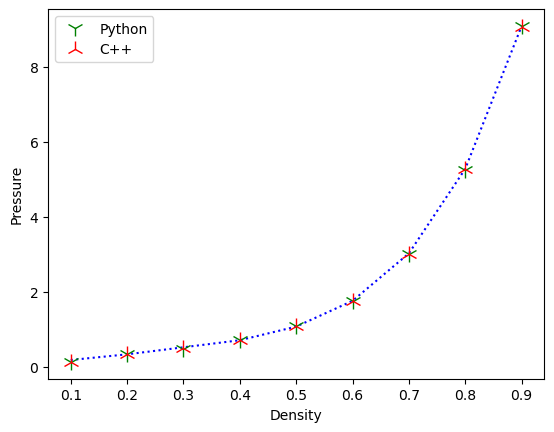

In [7]:
xx1 = np.array([0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
xx2 = np.arange(0.1, 1.0, 0.1)
yy1 = np.array([0.1777, 0.3290, 0.705, 1.069, 1.756, 3.024, 5.28, 9.09])

plt.plot( xx1, yy1, color="b", linestyle=":", marker="" )
plt.plot( xx2, presPY, color="g", linestyle="", marker="1", markersize=12, label="Python" )
plt.plot( xx2, presCPP, color="r", linestyle="", marker="2", markersize=12, label="C++" )

plt.xlabel("Density")
plt.ylabel("Pressure")

plt.legend()
plt.show()

# Data from MBWR paper 89 

In [17]:
totU = [
    [0.1, -0.669], [0.2, -1.308], [0.3, -1.922], [0.4, -2.539], [0.5, -3.149],
    [0.6, -3.747], [0.7, -4.3], [0.8, -4.752], [0.9, -5.025] 
    ]

totU = np.array( totU )

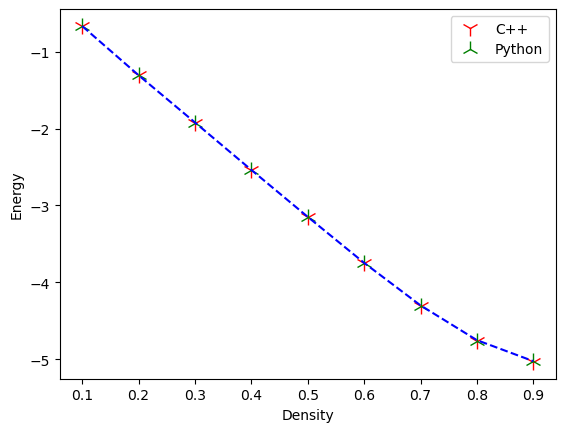

In [19]:
#np.mean( np.array(total[1000:] / 200) )
#total = np.array( [i.pot for i in totalEnergy] )

num = np.arange(100,1000,100)
up  = []
uc  = []
for i, t in enumerate(tT1):
    #total = t1 #np.array( [j.pot for j in t] )
    u1 = np.mean( np.array(t[1000:]) ) / num[i]
    u2 = np.mean( np.array(tT[i][1000:]) ) / num[i]
    uc.append(u1)
    up.append(u2)

uc = np.array(uc)
up = np.array(up)

plt.plot( num/1000, uc, color="r", linestyle="", marker="1", markersize=12, label="C++" )
plt.plot( num/1000, up, color="g", linestyle="", marker="2", markersize=12, label="Python" )
plt.plot( totU[:,0], totU[:,1], color="b", linestyle="--", marker="")

plt.xlabel("Density")
plt.ylabel("Energy")

plt.legend()
plt.show()

In [34]:
testChemPex =  [
[0.0015643994119181048, -0.04676014027405717],
[0.0235830983764104, -0.1399367366551898],
[0.054167170524627384, -0.27976527644299587],
[0.08841720712062667, -0.41949834840664124],
[0.10676612292437027, -0.4971455120575854],
[0.13734255764665443, -0.6057242507366922],
[0.16791517365597208, -0.6986780888614508],
[0.19970977781455057, -0.7916001043781549],
[0.2388324921557271, -0.8687062836921857],
[0.27550359277244924, -0.9146263071136254],
[0.29872518632137013, -0.9296465781149568],
[0.32316876801955186, -0.9446350265082337],
[0.3500486885903221, -0.9283100285767016],
[0.3964727821233317, -0.8802260678076124],
[0.4416596126552148, -0.7696743274291791],
[0.4782848887163397, -0.6280955441984197],
[0.5148948899255987, -0.4240171587502619],
[0.5417251672278055, -0.20456845361218345],
[0.5746462917114836, 0.09316386733791227],
[0.5990173178633028, 0.37504852947728207],
[0.6209443677166007, 0.6568695464005456],
[0.6392054531221161, 0.9385950954996467],
[0.6586770705379931, 1.2672271688698515],
[0.6757161677942479, 1.5489208953609],
[0.6915218207623425, 1.8774575009069432],
[0.7109743446133874, 2.2842140770488975],
[0.7206929691129768, 2.5188421662285743],
[0.7291896054633056, 2.7534384328001975],
[0.7437694515691731, 3.097568116292538],
[0.7510479184832074, 3.3165076597017578],
[0.7619694375672255, 3.6292920742612376],
[0.7789550728419501, 4.129734408513183],
[0.7910833052233632, 4.505050247898115],
[0.7959330706907417, 4.661426543873829]
]

testChemPex = np.array( testChemPex )

# data from Frenkel's book

In [30]:
import MBWR_EOS

test = {"temperature": 2.0, "sigma": 1., "component":1, "epsilon":1., "wave":1.0}
CP = []

mbwr = MBWR_EOS.MBWR_EOS(test)
for i in xx2:
    mbwr.rho = i
    chemP = mbwr.exChemicalPotential()
    CP.append(chemP)

CP = np.array( CP )


In [31]:
yy = np.array([ -0.124232,  -0.186052, -0.172991, -0.0584114, 0.244226, 0.771789, 1.7077 ])
xx = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ])

In [53]:
def uTail ( rho, rCut ):
    tail = (8./3.) * np.pi * rho * ( (1./3.) * (1./rCut)**9 - (1./rCut)**3 )
    return tail

tCPex = [ np.mean( np.array( i[2000:] ) ) for i in pot1 ]
tCPex = - np.log( tCPex )

xx2 = np.arange( 0.1, 1, 0.1 )
uts = []
for i in xx2:
    ut = uTail ( i, 2.5 )
    uts.append(ut)

tCPex = tCPex + 2*np.array( uts )

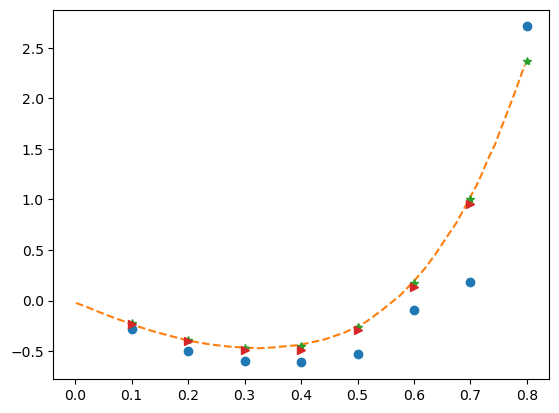

In [54]:
xx2 = np.arange(0.1, 1, 0.1)
plt.plot( xx2[:-1], tCPex[:-1], 'o' )
plt.plot( testChemPex[:,0], testChemPex[:,1]/2., "--")
plt.plot( xx2[:-1], CP[:-1,0,0], '*' )

plt.plot( xx, yy + 2*np.array(uts[:7]), ">" )

In [4]:
g_data = np.array([
[0.9053097583917941, 0.09677895709469198],
[0.9266080362185743, 0.284216474484988],
[0.938333714070804, 0.45684809909743507],
[0.9450616873413035, 0.6146665537919591],
[0.9551308969960147, 0.8025949473581164],
[0.9639660801097921, 1.0198522000946943],
[0.9723958015604889, 1.2594994486819941],
[0.9795657692073664, 1.4732905775496652],
[0.9871521326040503, 1.6881453265948847],
[0.997224962452182, 1.883839035047713],
[1.0064567864531933, 2.059785727742694],
[1.016510982412349, 2.2155097443423006],
[1.0332360003651648, 2.406462726816395],
[1.0665458561000984, 2.4876822256175695],
[1.0997508247913292, 2.3439190156763523],
[1.120473914526448, 2.189683339611305],
[1.1411897271214935, 2.019838198088787],
[1.1619028934837847, 1.8443168873090066],
[1.182619588156415, 1.6763638022055758],
[1.2033428984109298, 1.5226011402453006],
[1.2261482057910942, 1.3741959970148303],
[1.2531130550309415, 1.226955511223815],
[1.2863145953297135, 1.0758383994574725],
[1.3278401907396624, 0.9377142380084962],
[1.3735351174157922, 0.8217530109386595],
[1.419250191545844, 0.7490080725320687],
[1.4649800003810038, 0.7078690765806877],
[1.5107165250341374, 0.6811355101837218],
[1.5564642761292578, 0.6784826618478688],
[1.6022200461115106, 0.6930303264128099],
[1.6479811286064896, 0.7189733307745279],
[1.693753537779545, 0.7692120596086172],
[1.7395290542713635, 0.8261159871917645],
[1.785311186345067, 0.8972103379180676],
[1.8310940200713954, 0.9698097335231903],
[1.876879760644309, 1.048644315054851],
[1.9226601887044974, 1.116083556789735],
[1.9684335000023543, 1.168257343325164],
[2.0141965872191165, 1.1985004759120805],
[2.05994995153523, 1.2078879866067833],
[2.1056906861041087, 1.1901846894827348],
[2.1514231010775866, 1.1546358602241118],
[2.1971483992887335, 1.1038215757660343],
[2.2428752010412176, 1.056232387476855],
[2.2886020027937026, 1.0086431991876763],
[2.3343299071431676, 0.9634190814223564],
[2.380064427074518, 0.9323853868001923],
[2.4258026557411676, 0.9093069293946456],
[2.471543490546135, 0.891818638681857],
[2.508972591323648, 0.8877661222357798]
])

# data from Dean Frenkel Understanding molecular simulation, e82 Figure N.6


In [ ]:
system = {}

system["numberOfParticles"] = 512
system["density"]           = 0.8442
system["temperature"]       = 1.5043
system["rCut"]              = 2.5
system["cells"]             = np.array([8, 8, 8])
system["drMax"]             = 0.25

system["Version"]           = "CPP"
# system["isNeighborList"]    = False
system["isNeighborList"]    = True

# system["numberOfBlocks"]    = 10
# system["numberOfSteps"]     = 1000

# system["Filename"] = "trajectory.xyz"

In [ ]:
system["size"]              = system["cells"] / ( system["density"] ) ** (1./3.)
print( system["size"] )
print( np.prod(system["cells"]) / np.prod( system["size"] ) )

[8.46463439 8.46463439 8.46463439]
0.8442000000000002


In [11]:
MC = MonteCarlo(system)
# pressure, moveRatio, totalEnergy, pots, positions = MC.MC_NVT()
pressure, moveRatio, totalEnergy, pots, positions = MC.MC_NVT_CPP( nBlock=20, nStep=5000 )

pressure delta: -0.38054564069336366
Pressure lrc: -0.7621346985194898
Internal Energy LRC: -0.45201262476442317
sc = 3
cells: 8 8 8
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
Running Time: 478.312251329422 s


In [ ]:
positions = MonteCarlo.readXYZTrajectory("trajectory.xyz")

In [13]:
positions.shape

(5000, 512, 3)

In [14]:
rMid, g = MonteCarlo.rdf( positions[3000:], system["size"][0], 512, dr=0.02 )

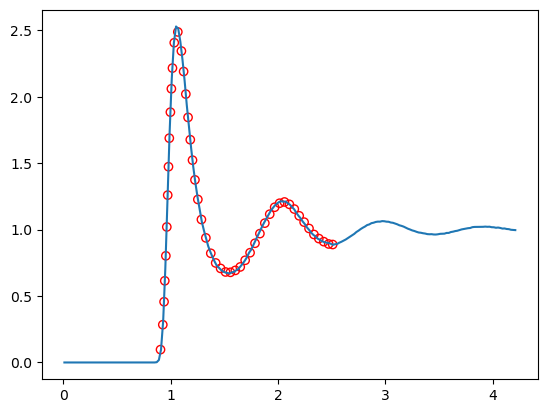

In [16]:
plt.plot( rMid, g )

plt.scatter( g_data[:,0], g_data[:,1], marker="o", edgecolors="r", color='none' )

plt.show()

In [ ]:
"""
1 2 3 4 5 6
6 1 2 3 4 5 (1, 6) (1, 2)
5 6 1 2 3 4 (1, 5) (1, 3)
4 5 6 1 2 3 (1, 4) (1, 4)
"""

"""
1 2 3 4 5
5 1 2 3 4 (1, 5) (1, 2)
4 5 1 2 3 (1, 4) (1, 3)
"""

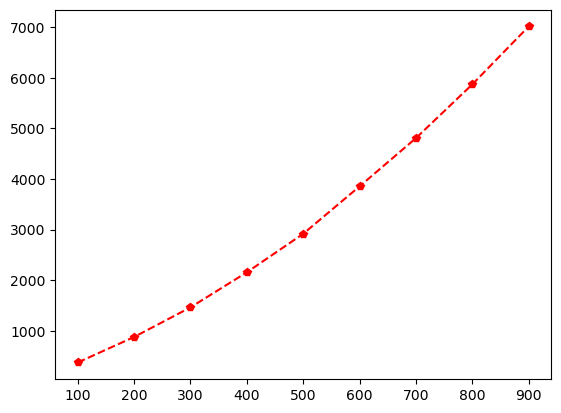

In [ ]:
# ytime = np.array( [ 6.16, 14.40, 24.25, 35.58, 48.39, 1.04.16, 1.20.09, 1.37.51, 1.56.55 ] )
h1 = np.array( [ 0, 0, 0, 0, 0, 1, 1, 1, 1 ] )
m1 = np.array( [ 6, 14, 24, 35, 48, 4, 20, 37, 56 ] )
s1 = np.array( [ 16, 40, 25, 58, 39, 16, 9, 51, 55 ] )

yTime = h1 * 3600 + m1 * 60 + s1
xTime = np.arange(100, 1000, 100)

plt.plot(xTime, yTime, color="red", linestyle = "--", marker="p")